In [92]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import mcnulty_util as mcu
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
df = mcu.mcnulty_preprocessing()

Initiating MAXIMUM data munging power
Luther Preprocessing Successful Woo Woo!



In [35]:
backup = df.copy()

## Filtering by Issue Year

In [4]:
(df
 .assign(issue_year=lambda x: x.issue_d.dt.year)
 .groupby('issue_year')
 .size()
)

issue_year
2007      251
2008     1562
2009     4716
2010    11527
2011    19729
2012    49813
2013    73194
2014    74153
2015    30832
dtype: int64

In [21]:
mask = (df.issue_d >= '2013') & (df.issue_d >= '2014')
df = df.loc[mask, ]

## One Hot Encoding Function

In [70]:
def one_hot_encoding_helper(input_df, column, drop_column=None):
    df = input_df.copy()
    x = df.loc[:, [column]]

    ohe = OneHotEncoder()
    ohe.fit(x)
    columns = list(ohe.categories_[0])
    emp_length_encoded = pd.DataFrame.sparse.from_spmatrix(ohe.transform(x), index=df.index, columns=columns)

    frames = [df, emp_length_encoded]
    df = (pd.concat(frames, axis=1)
        .drop(column, axis=1)
    )
    
    if drop_column:
        df = df.drop(drop_column, axis=1)
    
    """
    # Code to Check:
    (df
     .loc[:, columns + [column]]
     .head(25)
    )
    """
    
    return df, ohe

## Loan Amount

In [46]:
loan_amount_mean = df.loan_amnt.mean()
"${:,.0f}".format(loan_amount_mean)

'$14,417'

## Interest Rate

In [54]:
interest_rate_mean = df.int_rate.mean()
"{:,.2f}%".format(interest_rate_mean)

'14.26%'

## Annual Income

In [57]:
annual_income_mean = df.annual_inc.mean()
"${:,.0f}".format(annual_income_mean)

'$74,737'

## Debt-to-Income

In [7]:
dti_mean = df.dti.mean()
"${:,.2f}".format(dti_mean)

'$16.70'

## Employment Length

In [54]:
df.emp_length.mode().values[0]

'10+ years'

In [75]:
df, ohe_emp_length = one_hot_encoding_helper(df, 'emp_length', 'Not provided')

## Term

In [59]:
df.term.mode().values[0]

'36 months'

In [76]:
df, ohe_term = one_hot_encoding_helper(df, 'term', '60 months')

## Purpose

In [56]:
df.purpose.mode().values[0]

'debt_consolidation'

In [77]:
df, ohe_purpose = one_hot_encoding_helper(df, 'purpose', 'other')

## Grade

In [57]:
df.grade.mode().values[0]

'B'

In [78]:
df, ohe_emp_length = one_hot_encoding_helper(df, 'grade', 'G')

## Random Forest

In [82]:
%timeit
features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', '1 year', '10+ years', '2 years', '3 years',
            '4 years', '5 years', '6 years', '7 years', '8 years', '9 years',
            '< 1 year', '36 months', 'car', 'credit_card', 'debt_consolidation',
            'educational', 'home_improvement', 'house', 'major_purchase', 'medical',
            'moving', 'renewable_energy', 'small_business', 'vacation', 'wedding',
            'A', 'B', 'C', 'D', 'E', 'F'
           ]
dependent = 'default'
model_name = 'Random Forest'
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Model Evaluation

In [85]:
y_pred = rf.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

0.999960689616443

In [84]:
y_pred = rf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7770303396536195

## ROC Curve

[Reference Link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.671


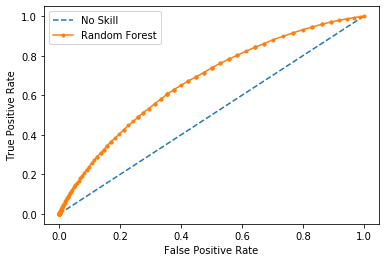

In [93]:
# predict probabilities and keep probabilities for the positive outcome only
y_pred_probs = rf.predict_proba(X_test)[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
rf_auc = metrics.roc_auc_score(y_test, y_pred_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, y_pred_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Precision-Recall Curve

[Reference Link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [97]:
y_test

id
17695381    0
1303263     0
6877263     1
39650138    1
13247623    1
           ..
24055881    0
10163319    0
14579873    0
10424820    0
11655084    1
Name: default, Length: 87707, dtype: int32

In [103]:
y_test.values.reshape(-1, 1)

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

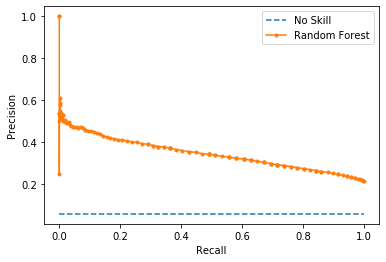

In [111]:
# predict probabilities and keep probabilities for the positive outcome only
y_pred_probs = rf.predict_proba(X_test)[:, 1]
# predict class values
y_pred = rf.predict(X_test)
# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_test, y_pred_probs)
# calculate scores
#rf_f1, rf_auc = metrics.f1_score(y_test, y_pred), metrics.auc(rf_precision, rf_recall)
# summarize scores
#print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
no_skill = len(y_pred[y_pred==1]) / len(y_pred)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Blog Testing

In [31]:
row = pd.DataFrame([[15000.0, 13.8, 74737, 16.7, '10+ years', '36 months', 'car', 'B']],
                  columns=features)

In [28]:
pipeline.predict(row)

array([0])

In [13]:
row = pd.DataFrame([[50, 13.8, '10+ years', 'MORTGAGE', 'car', '0', 15000.0, 13658.0, 'B', '36 months', 420.0, 'CA']],
                  columns=features)
pipeline.predict_proba(row)

array([[0.73, 0.27]])

## Pickling

In [29]:
import pickle

filename = 'clf.pkl'
with open(filename, 'wb') as f:
    pickle.dump(pipeline, f)